# Homework 3  - Part B


###### Roll Number: 20100120

We'll start Part B by taking out a minute to thank creators of Tensorflow and Keras for making our lives easier. The goal of this home work is to design a convolutional neural network to classify images from CIFAR-10. CIFAR-10 is a subset of CIFAR-100 with 10 and 100 being number of classes. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. We'll be building small CNNs using Keras to solve this classification task.
<br>

Please note:
- You have to save each trained model weights and tensorboard logs in different folder. Use proper names for the model
- You have to show trainings in this notebook file, so make sure that the printings and figures are available on this notebook file
- This notebook is also your report file. So add your comments and analysis of each task. Your comments and analysis are as important as your code. This would be considered short report and it is compulsory part of the homework.
- Your system memory may overflow. In that case, please reset memory for trained model(s) keeping printed logs and history of trained model. History of all trained models could be used to plot the trends.
- For trends you shall also use tensorboard logs 

### Imports

In [1]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [2]:
from google.colab import drive
drive.mount('drive')
import os
import zipfile
import numpy as np

dir = "/content/drive/My Drive/Datasets/"
files = os.listdir(dir)
files

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


['Fuel_Consumption.csv',
 'Web_New.csv',
 'Session_Data.json',
 'Sarcasm_Headlines_Dataset.json',
 'CIFAR.zip']

In [2]:
import keras
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, AveragePooling2D, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
from keras.utils import plot_model, to_categorical
import keras.backend as K

from sklearn.model_selection import train_test_split
from IPython.display import display

import cv2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import os
import glob
your_id = 20100120
np.random.seed(your_id)

Using TensorFlow backend.


In [0]:
zip_ref = zipfile.ZipFile(dir + 'CIFAR.zip', 'r')
zip_ref.extractall("/tmp/")
zip_ref.close()

###### Hyperparameters

In [0]:
batch_size = 64
num_classes = 10
class_labels = np.arange(0, num_classes, 1)
input_shape = (32,32,3)
epochs = 25
all_histories = []

### Task 1.1   Load dataset information
Download the [CIFAR-10 Dataset](https://drive.google.com/drive/folders/1FPsts3C2tJMVQ1xcCi2XZdb2z_J2OjSr?usp=sharing) and setup your working directory. Be sure to put the dataset in the <code>images_dir</code> directory. We won't be loading images and will only store the file paths in memory. These file paths will be used to load and return batch of images in our generator. Feel free to explore the dataset in this section.

In [0]:
train_dir = '/tmp/cifar/train/'
test_dir = '/tmp/cifar/test/'

In [7]:
labels_file = open('/tmp/cifar/labels.txt')
class_labels = labels_file.read()
class_names = class_labels.split('\n')

classes = {}
for i,cn in enumerate(class_names):
  classes[cn] = i
classes

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [8]:
path_images = os.listdir(train_dir)
path_images[:5]

['2399_horse.png',
 '6569_deer.png',
 '13414_frog.png',
 '40038_frog.png',
 '22822_automobile.png']

In [9]:
import glob
paths = []
labels = []

for i in range(len(class_names)):
    path = glob.glob(train_dir +'/*' + class_names[i] + '.png') # Groups together all the classes together
    for r in range(len(path)):
        labels.append(i)
    paths+=path        
print(len(paths))

50000


In [10]:
# After every 5000 images the next class of images comes
for i in range(len(paths)):
    if i % 5000 == 0:
        print (paths[i+1],"  & Label= ", labels[i+1])

/tmp/cifar/train/37690_airplane.png   & Label=  0
/tmp/cifar/train/26471_automobile.png   & Label=  1
/tmp/cifar/train/20645_bird.png   & Label=  2
/tmp/cifar/train/19837_cat.png   & Label=  3
/tmp/cifar/train/16073_deer.png   & Label=  4
/tmp/cifar/train/34059_dog.png   & Label=  5
/tmp/cifar/train/40038_frog.png   & Label=  6
/tmp/cifar/train/24026_horse.png   & Label=  7
/tmp/cifar/train/26454_ship.png   & Label=  8
/tmp/cifar/train/32838_truck.png   & Label=  9


In [11]:
# Training Validation Split
x_train ,x_val, y_train, y_val = train_test_split(paths, labels, test_size=0.2, random_state=your_id)

print(len(x_train), 'train samples')
print(len(x_val), 'validation samples')

40000 train samples
10000 validation samples


In [12]:
# Checking if the classes are balanced

countDict = {}
for i in range(len(class_names)):
  countDict[i] = y_train.count(i)
countDict

{0: 3935,
 1: 4014,
 2: 3974,
 3: 4010,
 4: 3993,
 5: 4010,
 6: 4007,
 7: 4053,
 8: 3982,
 9: 4022}

### Task 1.2 Preprocessing
Preprocessing of data such as normalization, mean shift, make the learning task simple for network and could accelerate the training process. 

###### Task 1.2.1 
In images, pixel values range from 0 to 255. To shift the values between (0,1) range, divide input image by 255.

In [0]:
def preprocessing_norm(images):
    processed_images = np.zeros(shape=(images.shape[0],32,32,3)) # Images shape = 64 (Batch_size), 32, 32, 3
    # for img in range(images.shape[0]):
    #   processed_images[img,:,:,:] = images[img,:,:,:]/255.0 # Putting  the normalized images in the processed images
    # processed_images = images/255.0
    for img in range(images.shape[0]):
      processed_images[img,:,:,:] = cv2.normalize(images[img,:,:,:], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return processed_images

###### Task 1.2.2
Compute the channel-wise mean and standard deviation (std). Subtract channel-wise mean and divide by channel-wise std. This will shift the mean to zero and variation to 1 for each channel. 

In [0]:
def preprocessing_meanShift(images):
    means = []
    stdevs = []
    processed_images = np.zeros(shape=(images.shape[0],32,32,3))
    
    # Taking the mean and standard deviation of every channel and subtarcting the channels with the mean and standard dev 
    for i in range(3):
        mean = np.mean(images[:,:,:,i])
        std = np.std(images[:,:,:,i])
        means.append(mean)
        stdevs.append(std)
        
    for i in range(3):
        processed_images[:,:,:,i] = ((images[:,:,:,i] - means[i])/ stdevs[i])
    
    return processed_images

In [15]:
batch_labels = to_categorical(labels, num_classes = 10)
# batch_labels = batch_labels.astype('int32') # Dont need this cause we want in floats
batch_labels.shape

(50000, 10)

### Task 1.3  Batch Generator
Previously, when training our models, we were loading the complete data in memory to fit our model. However, in practice we're working with very large datasets which cannot be loaded all at once in memory. As a solution, we use "Data Generators" which are essentially python generators that load batches of data from disk into memory and pass into our models. In order to achieve this, we only store filepaths that point to training/test samples in our dataset in memory. A data generator yields a tuple of (Xs,Ys) whenever the generator is used via the next() function. Implementation of a data generator is open ended, you can add whatever arguments you find necessary in addition to the ones provided.

#### Example for Yield

The yield statement suspends function’s execution and sends a value back to the caller, but retains enough state to enable function to resume where it is left off. 

When resumed, the function continues execution immediately after the last yield run. This allows its code to produce a series of values over time, 
rather than computing them at once and sending them back like a list.

A Python program to generate squares from 1 
to 100 using yield and therefore generator 

An infinite generator function that prints 
next square number. It starts with 1 

In [0]:
# import tensorflow as tf
def data_generator(images_paths,label_file, batch_size = 64, preprocessing = None):
  indexes = np.arange(0,len(images_paths), batch_size) # [0,64,128...]
    
  if len(images_paths) % batch_size != 0: # If remainder is not equal to 0 then dont take the last index
    indexes = indexes[:-1] 

  counter = 0
  
  while True:
      np.random.shuffle(indexes)
      for index in indexes:
          
          paths = images_paths[index : index + batch_size]
          labels = label_file[index : index + batch_size]

          # Convert the PNG paths to images and labels to arrays of size classes with 1 where the class is
          x_array = np.zeros((batch_size,32,32,3))
          y_array = np.zeros((batch_size,10))
          
          for i in range(len(paths)):
              x_array[i] = cv2.imread(paths[i])
          
          batch_labels = to_categorical(labels, num_classes = 10)
          batch_images = x_array

          if (preprocessing is None):
              pass
          elif (preprocessing == 'Normalize'):
              batch_images = preprocessing_norm(batch_images)
          elif (preprocessing == 'Mean_Shift'):
              batch_images = preprocessing_meanShift(batch_images)
          
          batch_x = np.array( batch_images )
          batch_y = np.array( batch_labels )
          yield( batch_x, batch_y )
          
  """
  Arguments
    ---------
    Images_paths : Array of paths of images you wish to train on.
    
    labels_file : Array that holds the images

    Preprocessing: Strings of Either None, Normalize or Mean_Shift
    
    Yields
    -------
    Tuple of (Batch X, Batch Y) which contains the labels and the training images
  """
      

In [0]:
class LRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        super(LRTensorBoard, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super(LRTensorBoard, self).on_epoch_end(epoch, logs)

In [0]:
model_name = 'base_model'

# Add the following callbacks to your Model: ModelCheckpoin, CSVLogger, ReduceLROnPlateau. The callback for Tensorboard has already been provided to you.
checkpoint = checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5',monitor='val_loss',
                            verbose=1, save_best_only=True, mode='auto')
csvlogger = cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, monitor='val_loss')
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, cvslogger, reducelr ,tensorboard]

### Task 1.4 Design CNN model
**IMPORTANT**: For each model you create, you need to conduct analysis in a markdown cell below the code cell containing the model's training. Your analysis should include plots, comments on its accuracy/loss, etc. Try to predict images and see what images your model is correctly classifying, see if your model is overfitting or not. For each layer you add, specify its function and then comment on its results.

In [19]:
# Design a CNN to predict classes for the images in the dataset. Try to keep your network shallow since you'll be training your model on your PC as well.

#TENSORFLOW 2
# from tensorflow import keras
# Input_image = keras.Input(shape=(input_shape))
# Conv1 = keras.layers.Conv2D(8, (3,3), strides=(2,2), activation= 'relu')(Input_image)
# Conv2 = keras.layers.Conv2D(16, (3,3), activation= 'relu')(Conv1)
# Flat = keras.layers.Flatten()(Conv2)
# Dense1 = keras.layers.Dense(44, activation= 'relu')(Flat)
# Output_class = keras.layers.Dense(num_classes, activation= 'softmax')(Dense1)

# model = keras.Model(inputs = Input_image, outputs = Output_class)
model_name = 'base_model'

Input_img = Input(shape=(input_shape), name='input_im')
Conv1 = Conv2D(16, kernel_size=(3, 3), strides = (2,2),  activation='relu')(Input_img)
Conv2 = Conv2D(32, (3, 3), strides = (2,2), activation='relu')(Conv1)
Flat = Flatten()(Conv2)
Dense1 = Dense(44, activation='relu')(Flat)
Output_class = Dense(num_classes, activation='softmax')(Dense1)

model = Model(inputs=Input_img, outputs=Output_class)

#### Compile model and plot

In [0]:
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
   

In [21]:
 # You may tweak the learning rate
# TENSORFLOW 2
# adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

adam = Adam(lr=0.001)
model.compile(optimizer= adam ,loss= 'categorical_crossentropy', metrics=['accuracy'])

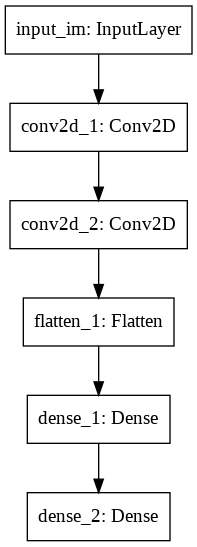

In [22]:
keras.utils.plot_model(model, model_name+'/'+model_name+'.png')

In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 44)                69036     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                450       
Total params: 74,574
Trainable params: 74,574
Non-trainable params: 0
_______________________________________________________

#### Task 1.5 Training model
In order to train the model, instead of "model.fit" function, we will use the "model.fit_generator" function for training. For details check out [keras documentation](https://keras.io/models/sequential/)

#### Task 1.5.1 (Base Model)
Train model without using any pre-processing scheme

In [0]:
# Create three generators: For training your model, for validation, for testing.
epochs = 25

train_gen = data_generator(x_train, y_train, batch_size, preprocessing = None)
val_gen = data_generator(x_val, y_val, batch_size)
#test_gen = data_generator(x_test, y_test, batch_size)

images_batch, labels_batch = val_gen.__next__()

In [25]:
print(images_batch.shape, labels_batch.shape)

(64, 32, 32, 3) (64, 10)


In [26]:
# Start training your model here

# Steps_per_epoch = the number of batch iterations before a training epoch is considered finished.
# Validation_steps = similar to steps_per_epoch but on the validation data set instead on the training data.

hist_initial = model.fit_generator( 
    train_gen,
    epochs=epochs,
    steps_per_epoch=len(y_train)//batch_size,
    verbose=1, 
    validation_data=val_gen,
    validation_steps=len(y_val)//batch_size, 
    callbacks=callbacks
    )



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










Epoch 1/25
625/625 [==============================] - 15s 24ms/step - loss: 2.2916 - acc: 0.2612 - val_loss: 1.6627 - val_acc: 0.3743

Epoch 00001: val_loss improved from inf to 1.66266, saving model to base_model/base_model-01-1.66.h5

Epoch 2/25
625/625 [==============================] - 8s 13ms/step - loss: 1.5221 - acc: 0.4420 - val_loss: 1.4335 - val_acc: 0.4807

Epoch 00002: val_loss improved from 1.66266 to 1.43350, saving model to base_model/base_model-02-1.43.h5
Epoch 3/25
625/625 [==============================] - 8s 13ms/step - loss: 1.3341 - acc: 0.5152 - val_loss: 1.3993 - val_acc: 0.5048

Epoch 00003: val_loss improved from 1.43350 to 1.39933, saving model to base_model/base_model-03-1.40.h5
Epoch 4/25
625/625 [==============================] - 8s 13ms/step - loss: 1.2347 - acc: 0.5550 - val_loss: 1.3465 - val_acc: 0.5203

Epoch 00004: val_loss improved from 1.39933 to 

In [0]:
all_histories = []
all_histories.append(hist_initial)
model.save(model_name + '.h5')

In [0]:
# base_model = pd.read_csv('base_model/logs.csv')
# x_axis = list(range(len(base_model)))
# plt.clf() 
# plt.plot(x_axis, base_model['val_acc'][0:len(base_model)], label='Validation')
# plt.plot(x_axis, base_model['acc'][0:len(base_model)], label='Training')
# plt.legend()
# plt.title('Accuracy')
# plt.show()

# plt.clf() 
# plt.plot(x_axis, base_model['loss'][0:len(base_model)], label='Training')
# plt.plot(x_axis, base_model['val_loss'][0:len(base_model)], label='Validation')
# plt.legend()
# plt.title('Loss')
# plt.show()

#### Task 1.5.2  (Normalized/ Mean Shift)
Train model by using data preprocessing i.e normalization or mean shift. 

In [0]:
train_gen = data_generator(x_train, y_train, batch_size, preprocessing = 'Normalize')
val_gen = data_generator(x_val, y_val, batch_size)

In [0]:
Input_img = Input(shape=(input_shape), name='input_img')
Conv1 = Conv2D(32, kernel_size=(3, 3), strides = (2,2),  activation='relu')(Input_img)
Conv2 = Conv2D(64, (3, 3), strides = (2,2), activation='relu')(Conv1)
# Conv3 = Conv2D(64, (3, 3), strides = (2,2), activation='relu')(Conv2)
Flat = Flatten()(Conv2)
Dense1 = Dense(44, activation='relu')(Flat)
Output_class = Dense(num_classes, activation='softmax')(Dense1)

model_preprocessed = Model(inputs=Input_img, outputs=Output_class)

In [0]:
model_name = 'processed_model'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    

In [0]:
# You may tweak this Learning Rate
adam = Adam(lr=0.001)
model_preprocessed.compile(optimizer= adam ,loss= 'categorical_crossentropy', metrics=['accuracy'])

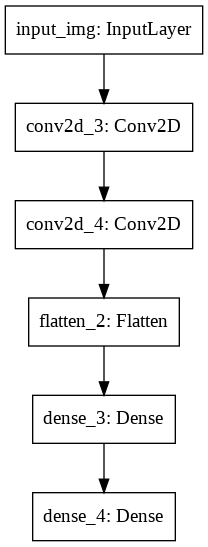

In [32]:
plot_model(model_preprocessed, model_name+'/'+model_name+'.png')

In [33]:
model_preprocessed.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 44)                138028    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                450       
Total params: 157,870
Trainable params: 157,870
Non-trainable params: 0
_____________________________________________________

In [0]:
# Add the following callbacks to your Model: ModelCheckpoin, CSVLogger, ReduceLROnPlateau. The callback for Tensorboard has already been provided to you.
checkpoint = checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5',monitor='val_loss',
                            verbose=1, save_best_only=True, mode='auto')
csvlogger = cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, monitor='val_loss')
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, cvslogger, reducelr ,tensorboard]

In [35]:
callbacks = [checkpoint, cvslogger, reducelr ,tensorboard]

hist_preprocessed = model_preprocessed.fit_generator( 
    train_gen,
    epochs=epochs,
    steps_per_epoch=len(y_train)//batch_size,
    verbose=1, 
    validation_data=val_gen,
    validation_steps=len(y_val)//batch_size, 
    callbacks=callbacks
    )

Epoch 1/25
625/625 [==============================] - 9s 15ms/step - loss: 1.5830 - acc: 0.4314 - val_loss: 8.4950 - val_acc: 0.4621

Epoch 00001: val_loss improved from inf to 8.49496, saving model to processed_model/processed_model-01-8.49.h5
Epoch 2/25
625/625 [==============================] - 9s 14ms/step - loss: 1.2527 - acc: 0.5571 - val_loss: 9.2389 - val_acc: 0.4189

Epoch 00002: val_loss did not improve from 8.49496
Epoch 3/25
625/625 [==============================] - 9s 14ms/step - loss: 1.1072 - acc: 0.6082 - val_loss: 7.4108 - val_acc: 0.5320

Epoch 00003: val_loss improved from 8.49496 to 7.41077, saving model to processed_model/processed_model-03-7.41.h5
Epoch 4/25
625/625 [==============================] - 9s 14ms/step - loss: 1.0043 - acc: 0.6484 - val_loss: 7.6426 - val_acc: 0.5183

Epoch 00004: val_loss did not improve from 7.41077
Epoch 5/25
625/625 [==============================] - 9s 14ms/step - loss: 0.9284 - acc: 0.6761 - val_loss: 7.5548 - val_acc: 0.5230

Ep

In [0]:
all_histories.append(hist_preprocessed)
model_preprocessed.save(model_name + '.h5')

### Task 2.1 Pooling
Now, you need to modify the model by adding pooling layer(s). Pooling could be average pooling or max pooling. You can use the size and stride for pooling of your choice. 
<br> 
Modify the network by introducing pooling layer and train the model using the __fit_generator__ function. 

In [0]:
model_name = 'model_pooling'

Input_img = Input(shape=(input_shape), name='input_img')
Conv1 = Conv2D(64, kernel_size=(3, 3), strides = (2,2),  activation='relu')(Input_img)
Pool1 = AveragePooling2D(pool_size=(2,2), padding='same')(Conv1)
Conv2 = Conv2D(128, (3, 3), strides = (2,2), activation='relu')(Pool1)
Pool2 = AveragePooling2D(pool_size=(2,2), padding='same')(Conv2)
Flat = Flatten()(Pool2)
Dense1 = Dense(44, activation='relu')(Flat)
Output_class = Dense(num_classes, activation='softmax')(Dense1)

model_pooled = Model(inputs=Input_img, outputs=Output_class)

In [0]:
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
adam = Adam(lr=0.001)
model_pooled.compile(optimizer= adam ,loss= 'categorical_crossentropy', metrics=['accuracy'])

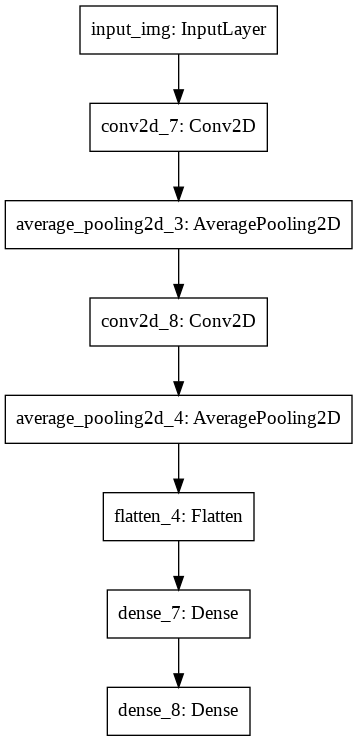

In [48]:
plot_model(model_pooled, model_name+'/'+model_name+'.png')

In [49]:
model_pooled.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        1792      
_________________________________________________________________
average_pooling2d_3 (Average (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
average_pooling2d_4 (Average (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 44)                2257

In [0]:
train_gen = data_generator(x_train, y_train, batch_size, preprocessing = None)
val_gen = data_generator(x_val, y_val, batch_size)
#test_gen = data_generator(x_test, y_test, batch_size)

images_batch, labels_batch = val_gen.__next__()

In [0]:
# Add the following callbacks to your Model: ModelCheckpoin, CSVLogger, ReduceLROnPlateau. The callback for Tensorboard has already been provided to you.
checkpoint = checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5',monitor='val_loss',
                            verbose=1, save_best_only=True, mode='auto')
csvlogger = cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, monitor='val_loss')
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, cvslogger, reducelr ,tensorboard]

In [52]:
callbacks = [checkpoint, cvslogger, tensorboard]

hist_pooled = model_pooled.fit_generator( 
    train_gen,
    epochs=epochs,
    steps_per_epoch=len(y_train)//batch_size,
    verbose=1, 
    validation_data=val_gen,
    validation_steps=len(y_val)//batch_size, 
    callbacks=callbacks
    )


Epoch 1/25
625/625 [==============================] - 8s 13ms/step - loss: 2.9827 - acc: 0.3671 - val_loss: 1.4573 - val_acc: 0.4749

Epoch 00001: val_loss improved from inf to 1.45730, saving model to model_pooling/model_pooling-01-1.46.h5
Epoch 2/25
625/625 [==============================] - 8s 13ms/step - loss: 1.3514 - acc: 0.5160 - val_loss: 1.3014 - val_acc: 0.5389

Epoch 00002: val_loss improved from 1.45730 to 1.30139, saving model to model_pooling/model_pooling-02-1.30.h5
Epoch 3/25
625/625 [==============================] - 8s 13ms/step - loss: 1.1953 - acc: 0.5752 - val_loss: 1.2293 - val_acc: 0.5679

Epoch 00003: val_loss improved from 1.30139 to 1.22931, saving model to model_pooling/model_pooling-03-1.23.h5
Epoch 4/25
625/625 [==============================] - 8s 13ms/step - loss: 1.0876 - acc: 0.6161 - val_loss: 1.1993 - val_acc: 0.5806

Epoch 00004: val_loss improved from 1.22931 to 1.19926, saving model to model_pooling/model_pooling-04-1.20.h5
Epoch 5/25
625/625 [====

In [0]:
# %load_ext tensorboard
# %tensorboard --logdir {model_name}

In [0]:
all_histories.append(hist_pooled)
model_pooled.save(model_name + '.h5')

### Task 3.1 Dropout
Modify the network by introducing dropout layer(s) and train the model using the __fit_generator__ function. 

In [0]:
model_name = 'model_dropout'

Input_img = Input(shape=(input_shape), name='input_img')
Conv1 = Conv2D(64, kernel_size=(3, 3), strides = (2,2),  activation='relu')(Input_img)
Dropout1 = Dropout(0.2)(Conv1)
Pool1 = AveragePooling2D(pool_size=(2,2), padding='same')(Dropout1)
Conv2 = Conv2D(128, (3, 3), strides = (2,2), activation='relu')(Pool1)
Dropout2 = Dropout(0.2)(Conv2)
Pool2 = AveragePooling2D(pool_size=(2,2), padding='same')(Dropout2)
Flat = Flatten()(Pool2)
Dense1 = Dense(44, activation='relu')(Flat)
Output_class = Dense(num_classes, activation='softmax')(Dense1)


model_dropout = Model(inputs=Input_img, outputs=Output_class)

In [0]:
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
adam = Adam(lr=0.001)
model_dropout.compile(optimizer= adam ,loss= 'categorical_crossentropy', metrics=['accuracy'])

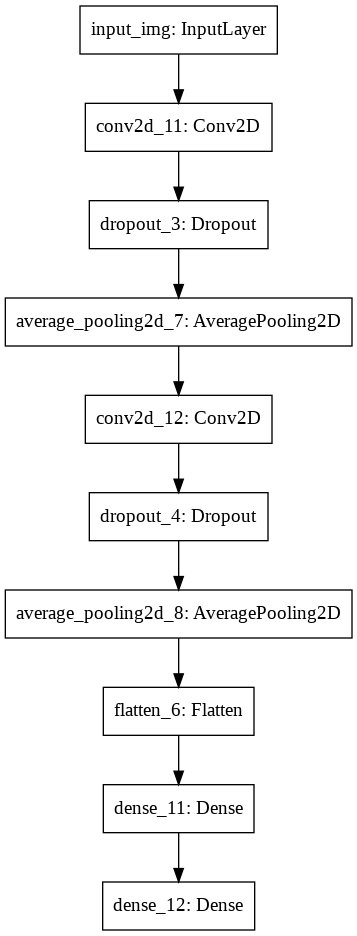

In [65]:
plot_model(model_dropout, model_name+'/'+model_name+'.png')

In [66]:
model_dropout.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 64)        1792      
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
average_pooling2d_7 (Average (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 3, 128)         0         
_________________________________________________________________
average_pooling2d_8 (Average (None, 2, 2, 128)         0   

In [0]:
train_gen = data_generator(x_train, y_train, batch_size, preprocessing = None)
val_gen = data_generator(x_val, y_val, batch_size)
#test_gen = data_generator(x_test, y_test, batch_size)

In [0]:
# Add the following callbacks to your Model: ModelCheckpoin, CSVLogger, ReduceLROnPlateau. The callback for Tensorboard has already been provided to you.
checkpoint = checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5',monitor='val_loss',
                            verbose=1, save_best_only=True, mode='auto')
csvlogger = cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, monitor='val_loss')
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, cvslogger, reducelr ,tensorboard]

In [69]:
callbacks = [checkpoint, cvslogger, tensorboard]

hist_dropout = model_dropout.fit_generator( 
    train_gen,
    epochs=epochs,
    steps_per_epoch=len(y_train)//batch_size,
    verbose=1, 
    validation_data=val_gen,
    validation_steps=len(y_val)//batch_size, 
    callbacks=callbacks
    )

Epoch 1/25
625/625 [==============================] - 9s 14ms/step - loss: 2.0403 - acc: 0.3618 - val_loss: 1.4854 - val_acc: 0.4632

Epoch 00001: val_loss improved from inf to 1.48537, saving model to model_dropout/model_dropout-01-1.49.h5
Epoch 2/25
625/625 [==============================] - 8s 13ms/step - loss: 1.4352 - acc: 0.4803 - val_loss: 1.3175 - val_acc: 0.5278

Epoch 00002: val_loss improved from 1.48537 to 1.31746, saving model to model_dropout/model_dropout-02-1.32.h5
Epoch 3/25
625/625 [==============================] - 8s 13ms/step - loss: 1.3141 - acc: 0.5308 - val_loss: 1.2484 - val_acc: 0.5544

Epoch 00003: val_loss improved from 1.31746 to 1.24843, saving model to model_dropout/model_dropout-03-1.25.h5
Epoch 4/25
625/625 [==============================] - 8s 13ms/step - loss: 1.2425 - acc: 0.5575 - val_loss: 1.1810 - val_acc: 0.5903

Epoch 00004: val_loss improved from 1.24843 to 1.18097, saving model to model_dropout/model_dropout-04-1.18.h5
Epoch 5/25
625/625 [====

In [0]:
# %load_ext tensorboard
# %tensorboard --logdir {model_name}

In [0]:
all_histories.append(hist_dropout)
model_dropout.save(model_name + '.h5')

### Task 4.1 Batch Normalization
Modify the network by introducing batch normalization layer(s) and train the model. 

In [0]:
model_name = 'model_batch_normalized'

Input_img = Input(shape=(input_shape), name='input_img')

Conv1 = Conv2D(32, kernel_size=(3, 3), strides = (2,2))(Input_img)
# Batchnorm1 = BatchNormalization()(Conv1)
Act1 = Activation('relu')(Conv1)
# Pool1 = MaxPooling2D(pool_size=(2,2), padding='same')(Act1)

Conv2 = Conv2D(64, (3, 3), strides = (2,2))(Act1)
Batchnorm2 = BatchNormalization()(Conv2)
Act2 = Activation('relu')(Batchnorm2)
Pool2 = MaxPooling2D(pool_size=(2,2), padding='same')(Act2)
Dropout1 = Dropout(0.2)(Pool2)

Conv3 = Conv2D(128, (3, 3), strides = (1,1))(Dropout1)
Batchnorm3 = BatchNormalization()(Conv3)
Act3 = Activation('relu')(Batchnorm3)
Pool3 = MaxPooling2D(pool_size=(2,2), padding='same')(Act3)
Dropout2 = Dropout(0.3)(Pool3)

Flat = Flatten()(Dropout2)
Dense1 = Dense(128, activation='relu')(Flat)
Dense2 = Dense(64, activation='relu')(Dense1)
Output_class = Dense(num_classes, activation='softmax')(Dense2)


model_normalized = Model(inputs=Input_img, outputs=Output_class)

In [0]:
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
adam = Adam(lr=0.001)
model_normalized.compile(optimizer= adam ,loss= 'categorical_crossentropy', metrics=['accuracy'])

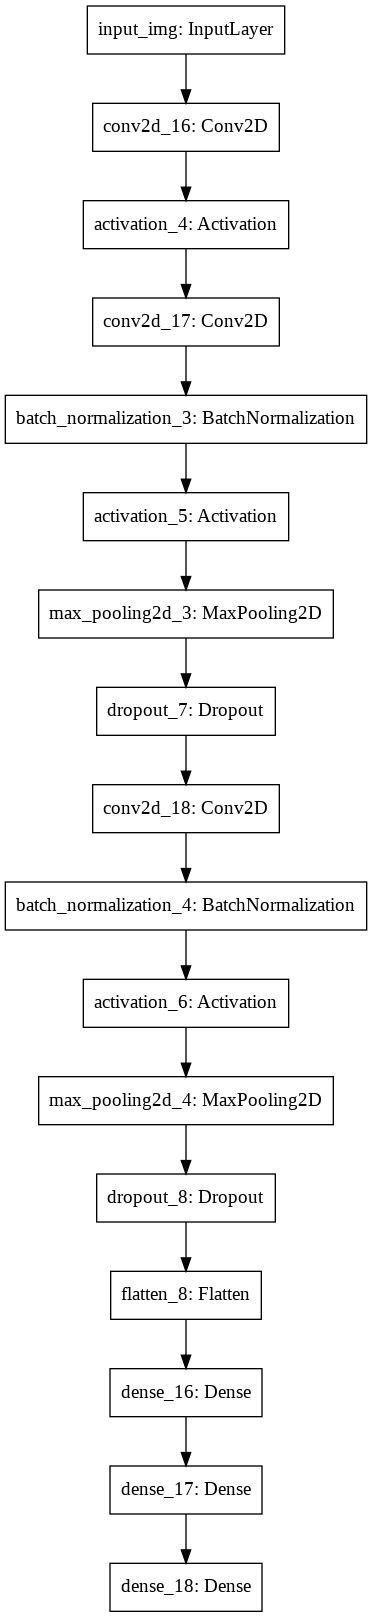

In [81]:
plot_model(model_normalized, model_name+'/'+model_name+'.png')

In [82]:
model_normalized.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
activation_4 (Activation)    (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
activation_5 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0   

In [0]:
train_gen = data_generator(x_train, y_train, batch_size, preprocessing = None)
val_gen = data_generator(x_val, y_val, batch_size)
#test_gen = data_generator(x_test, y_test, batch_size)

In [0]:
# Add the following callbacks to your Model: ModelCheckpoin, CSVLogger, ReduceLROnPlateau. The callback for Tensorboard has already been provided to you.
checkpoint = checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5',monitor='val_loss',
                            verbose=1, save_best_only=True, mode='auto')
csvlogger = cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, monitor='val_loss')
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, cvslogger, reducelr ,tensorboard]

In [85]:
callbacks = [checkpoint, cvslogger, tensorboard]

hist_normalized = model_normalized.fit_generator( 
    train_gen,
    epochs=epochs,
    steps_per_epoch=len(y_train)//batch_size,
    verbose=1, 
    validation_data=val_gen,
    validation_steps=len(y_val)//batch_size, 
    callbacks=callbacks
    )

Epoch 1/25
625/625 [==============================] - 11s 17ms/step - loss: 1.6569 - acc: 0.3867 - val_loss: 1.6359 - val_acc: 0.4414

Epoch 00001: val_loss improved from inf to 1.63594, saving model to model_batch_normalized/model_batch_normalized-01-1.64.h5
Epoch 2/25
625/625 [==============================] - 10s 15ms/step - loss: 1.3945 - acc: 0.4852 - val_loss: 1.3087 - val_acc: 0.5204

Epoch 00002: val_loss improved from 1.63594 to 1.30872, saving model to model_batch_normalized/model_batch_normalized-02-1.31.h5
Epoch 3/25
625/625 [==============================] - 10s 16ms/step - loss: 1.2732 - acc: 0.5370 - val_loss: 1.2012 - val_acc: 0.5658

Epoch 00003: val_loss improved from 1.30872 to 1.20117, saving model to model_batch_normalized/model_batch_normalized-03-1.20.h5
Epoch 4/25
625/625 [==============================] - 10s 15ms/step - loss: 1.1958 - acc: 0.5676 - val_loss: 1.1942 - val_acc: 0.5619

Epoch 00004: val_loss improved from 1.20117 to 1.19417, saving model to model

In [0]:
# %load_ext tensorboard
# %tensorboard --logdir {model_name}

In [0]:
all_histories.append(hist_normalized)
model_normalized.save(model_name + '.h5')

### Task 5.1 Comparison of all models
In this task you need to plot the loss and accuracy for all models and __discuss__ which model has better performance and why do you think so.

In [0]:
# Plot accuracy of all models
def plotHistory(histories, names, metric):
    plt.clf() 
    x_axis = list(range(epochs))
    for hist, name in zip(histories, names):
        plt.plot(x_axis, hist.history[metric], label=metric+'_'+name)
        plt.scatter(x_axis, hist.history[metric])
    plt.legend()
    plt.title(metric)
    plt.show()

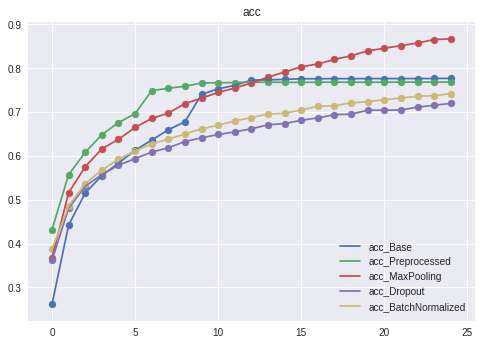

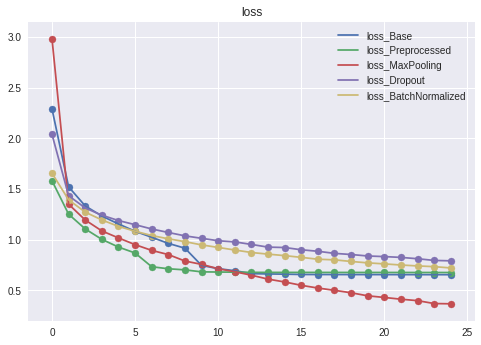

In [88]:
# Plot histories of all models
labels = ['Base', 'Preprocessed', 'MaxPooling', 'Dropout', 'BatchNormalized']
plotHistory(all_histories, labels, 'acc')
plotHistory(all_histories, labels, 'loss')

#### Tensorboard 

You can run TensorBoard using the following command
```tensorboard --logdir=path/to/log-directory
```
Now for logs of all above trained models, take snapshot of the _loss_ and _accuracy_ plots and save in the directory where this notebook is. To show that saved plot here in notebook use following command in _markdown_ cell. 
<br> __![](path_to_image)__

**Add cells to include loss plots**

In [5]:
from google.colab import drive
drive.mount('drive')
import os

pics_dir = "/content/drive/My Drive/Colab Notebooks/Deep Learning/Acc_Loss Pic/"
pics = os.listdir(pics_dir)
pics

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


['Base_Acc.PNG',
 'Preprocessed_Acc.PNG',
 'Dropout_Loss.PNG',
 'Pooling_Acc.PNG',
 'Base_Loss.PNG',
 'Normalized_Acc.PNG',
 'Dropout_Acc.PNG',
 'Pooling_Loss.PNG',
 'Normalized_Loss.PNG',
 'Preprocessed_Loss.PNG',
 'Lr.png']

### Base Model Tensorboard

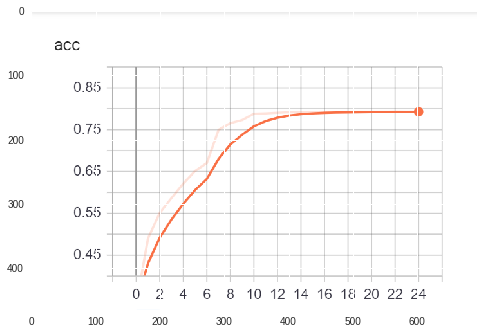

In [42]:
plt.imshow(cv2.cvtColor(cv2.imread(pics_dir + 'Base_Acc.PNG'), cv2.COLOR_BGR2RGB))

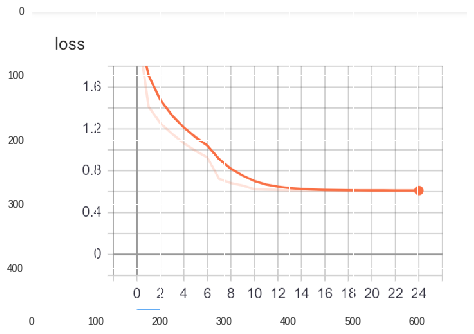

In [43]:
plt.imshow(cv2.cvtColor(cv2.imread(pics_dir + 'Base_Loss.PNG'), cv2.COLOR_BGR2RGB))

### Preprocessed Model Tensorboard

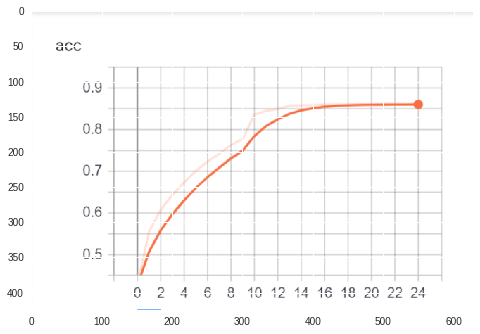

In [44]:
plt.imshow(cv2.cvtColor(cv2.imread(pics_dir + 'Preprocessed_Acc.PNG'), cv2.COLOR_BGR2RGB))

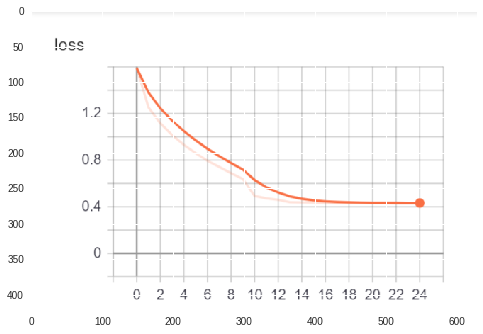

In [45]:
plt.imshow(cv2.cvtColor(cv2.imread(pics_dir + 'Preprocessed_Loss.PNG'), cv2.COLOR_BGR2RGB))

### Pooling Model Tensorboard

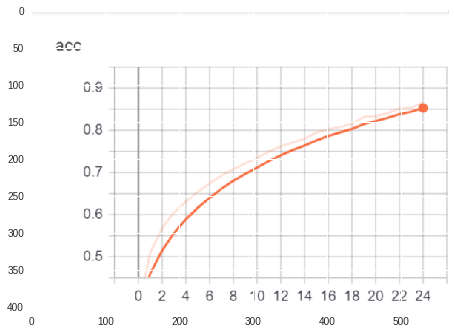

In [46]:
plt.imshow(cv2.cvtColor(cv2.imread(pics_dir + 'Pooling_Acc.PNG'), cv2.COLOR_BGR2RGB))

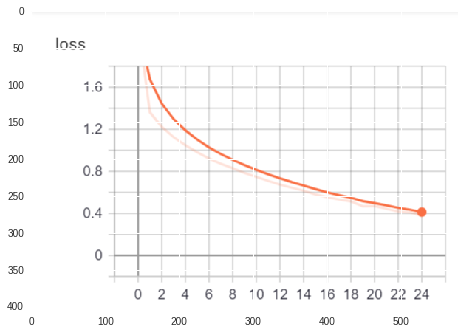

In [47]:
plt.imshow(cv2.cvtColor(cv2.imread(pics_dir + 'Pooling_Loss.PNG'), cv2.COLOR_BGR2RGB))

### Dropout Model Tensorboard

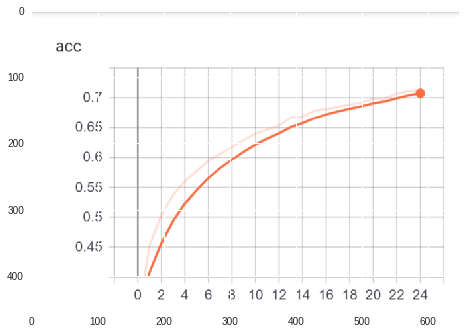

In [48]:
plt.imshow(cv2.cvtColor(cv2.imread(pics_dir + 'Dropout_Acc.PNG'), cv2.COLOR_BGR2RGB))

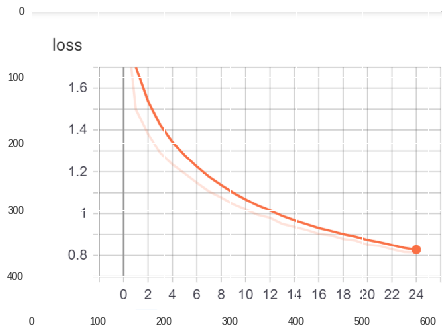

In [49]:
plt.imshow(cv2.cvtColor(cv2.imread(pics_dir + 'Dropout_Loss.PNG'), cv2.COLOR_BGR2RGB))

### Batch Normalized Model Tensorboard

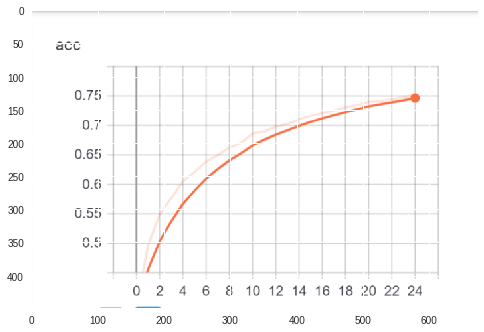

In [50]:
plt.imshow(cv2.cvtColor(cv2.imread(pics_dir + 'Normalized_Acc.PNG'), cv2.COLOR_BGR2RGB))

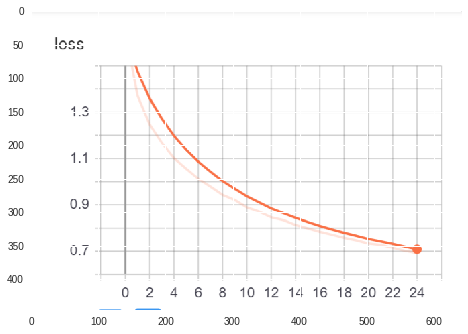

In [51]:
plt.imshow(cv2.cvtColor(cv2.imread(pics_dir + 'Normalized_Loss.PNG'), cv2.COLOR_BGR2RGB))

First with the base model we can see that the accuracy is around 0.5 which means that this model does work as it is better than the random classification which would be 0.1.

After Pooling our accuracy increases to around 0.6 - 0.65, this is probably because our images have sharp edges for each class of images thus max/average pooling helps extracting the iimportant features which iimproves our accuracy.

In Dropout we not only see our val_acc increase but our train_acc decrease that is because Dropout is a regularizer which increases bias but decreases the variance.Thus giving a good accuracy of 0.65

Finally in the last model Batch Normalization The idea is to normalise the inputs of each layer in such a way that they have a mean output activation of zero and standard deviation of one. This is analogous to how the inputs to networks are standardised.

Advantages of Batch NOrmalization:
- Networks train faster (converge much more quickly)
- allows higher learning rates
- Makes weights easier to initialize (Batch normalisation helps reduce the sensitivity to the initial starting weights.)
- Makes more activation functions viable (batch normalisation regulates the values going into each activation function, nonlinearities that don’t work well in deep networks tend to become viable again.)
- Provides some regularisation

To conclude the Pooling, Drop out and Batch Normalization had a great effect on increasing the val_acc, as did increasing another layer and increasing the filter sizes in power of 2s

The main analysis is that all the models over fitted by training well on the training images but poorly on the validation set. Only after adding the regularizers, Dropout and Batch Normalization did the Val_acc increase and the train_acc was more closer to it. This shows how these two helped to increase our accuracy on unseen data

### Task 5.2 Visualize Activations
We will be covering this in Friday's tutorial. You can complete this part after the tutorial (21st Feb 2020). In this task, you are required to visualize the activations (outputs) of both the convolution layers of a model.

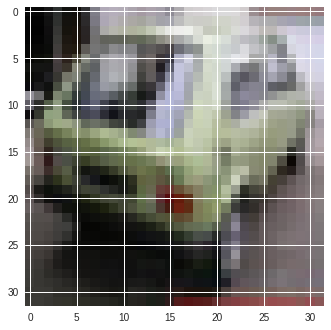

In [92]:
# Load any image here
test_path = os.listdir(test_dir)
test_image = cv2.cvtColor(cv2.imread(test_dir+test_path[10]), cv2.COLOR_BGR2RGB)

plt.imshow(test_image)

In [93]:
# Get a prediction from ANY ONE of your models and output its label
test_reshaped = test_image.reshape((1,32,32,3))
pred = model_pooled.predict(test_reshaped)
print('Label: ', class_names[np.argmax(pred)])

Label:  automobile


In [0]:
# Create a Model from the Input layer to a Convolutional Layer
layer_outputs = [layer.output for layer in model_pooled.layers]

pred_model = Model(inputs=model_pooled.input, outputs=layer_outputs[1])

In [0]:
# Get a prediction for your chosen image using this model
predicted_activations = pred_model.predict(test_reshaped)

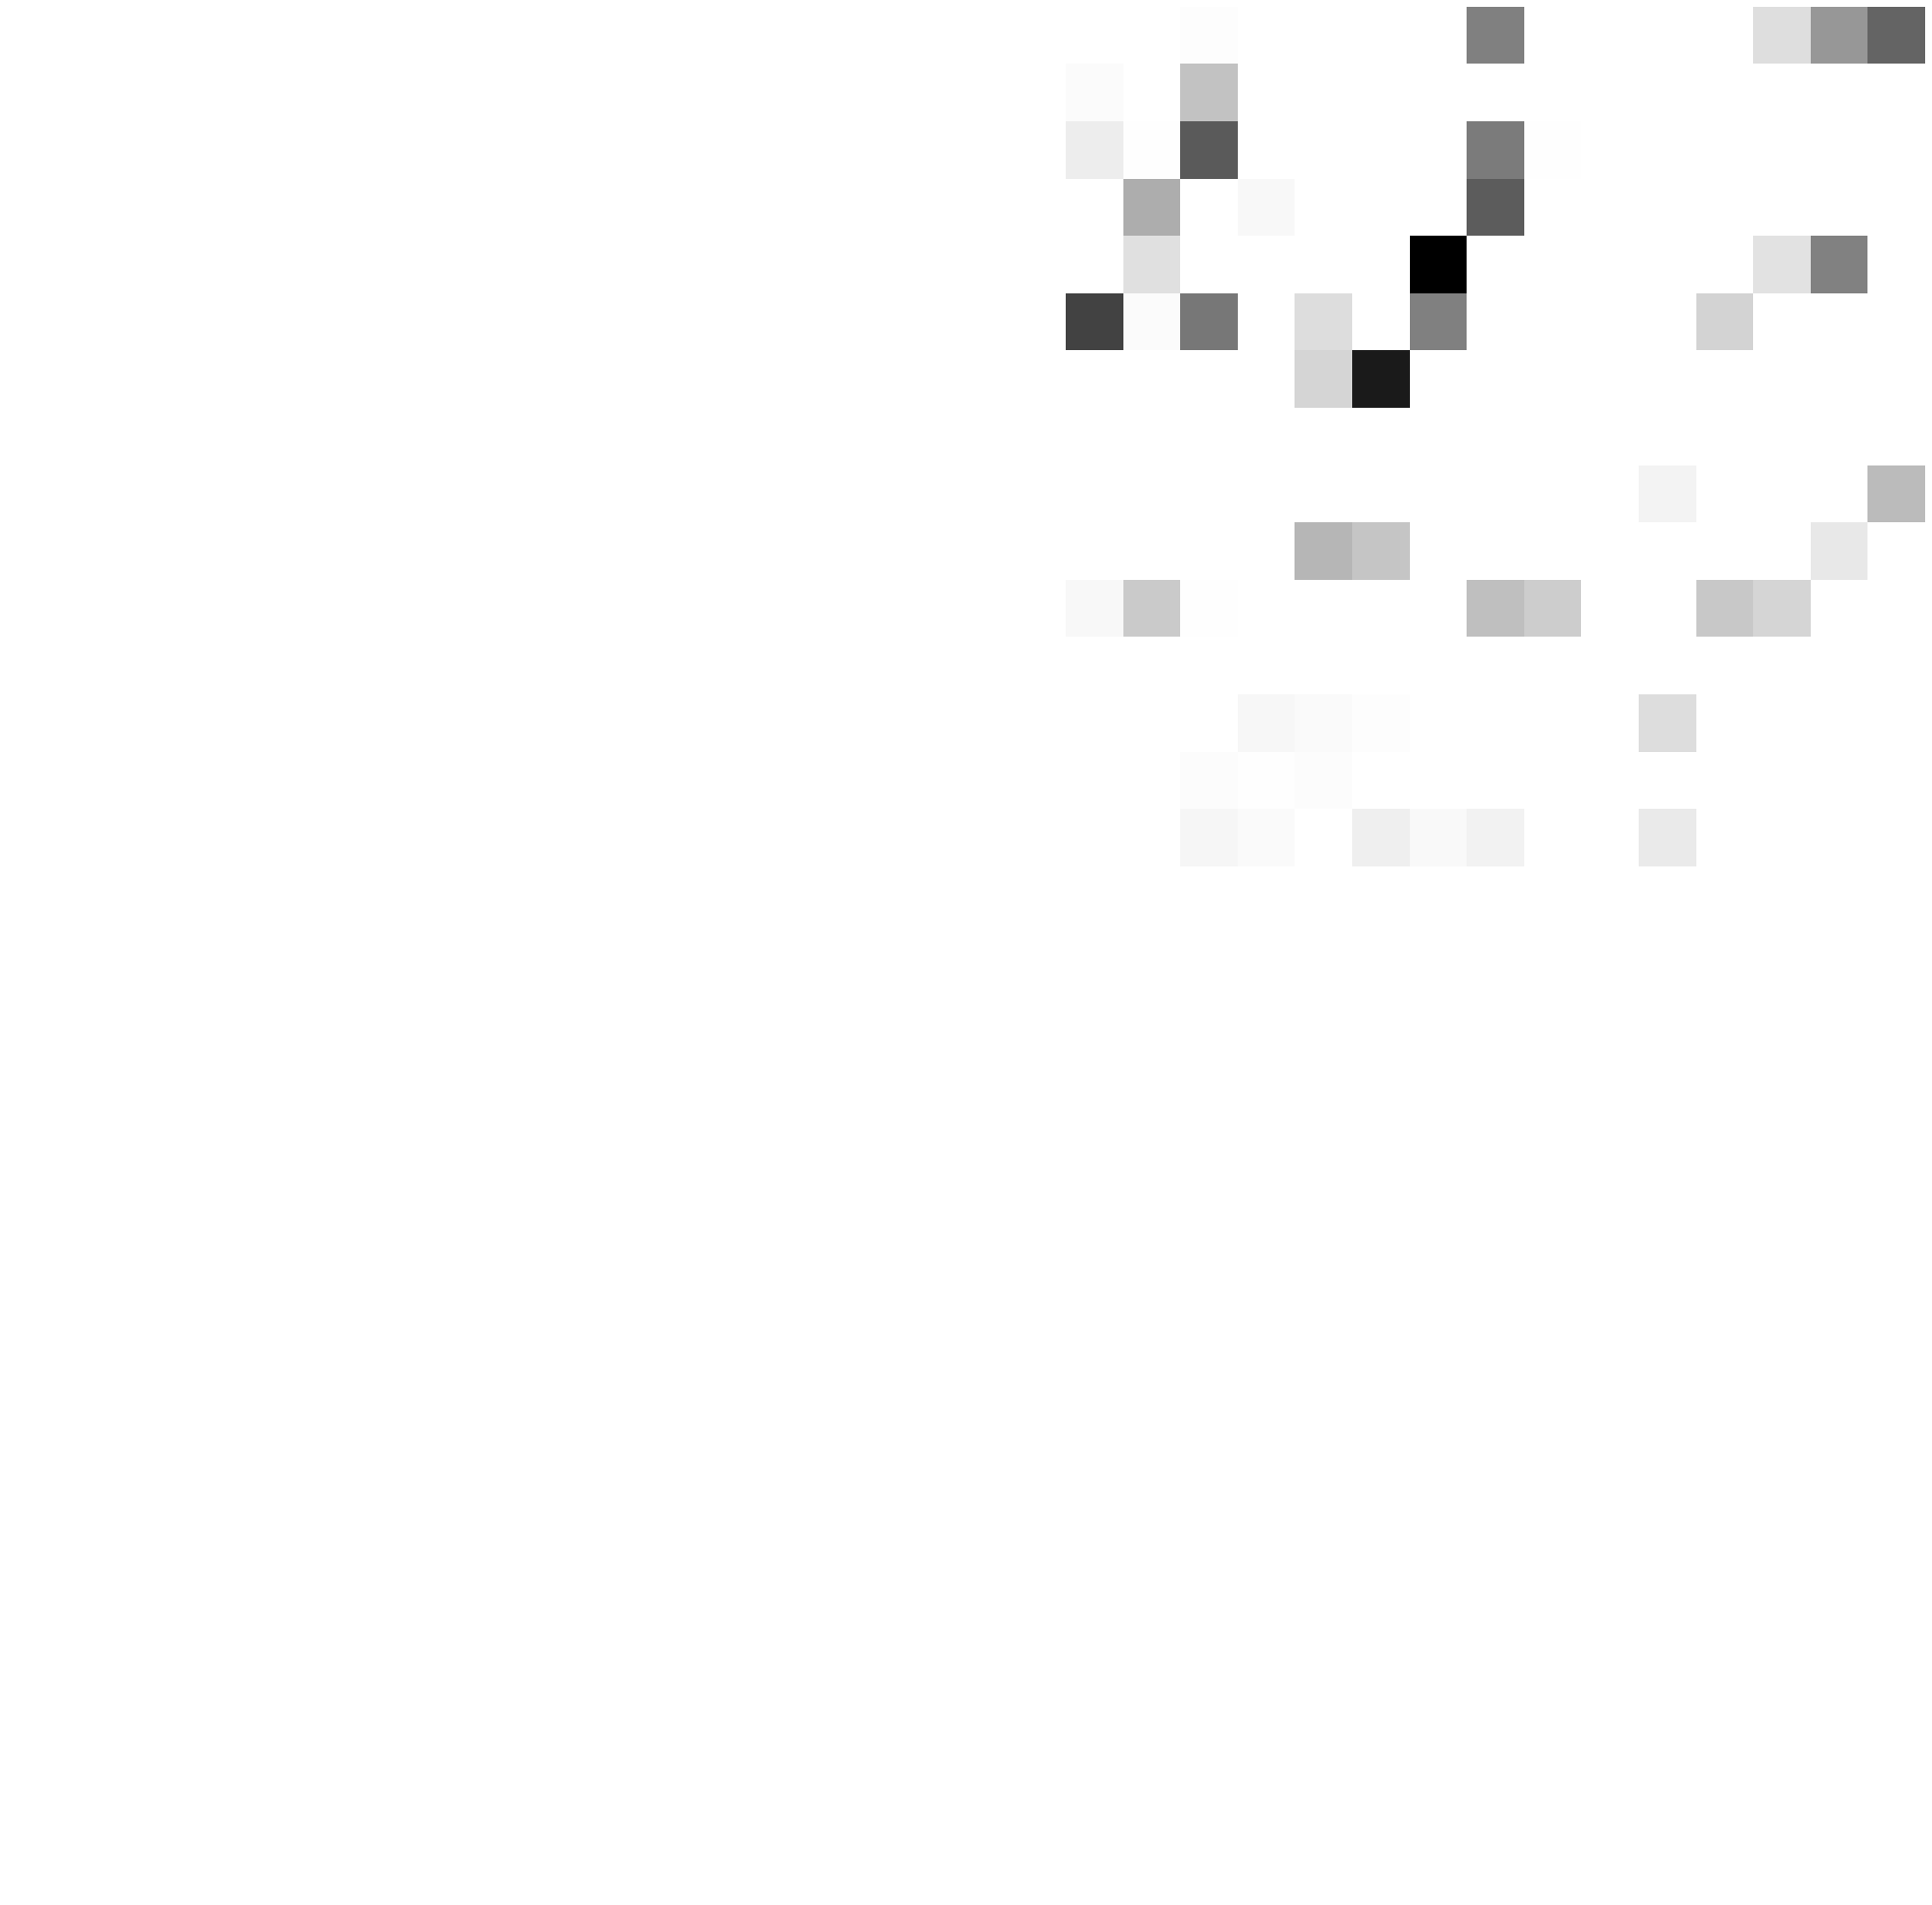

In [96]:
# Use your predictions to visualise the activations
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(32,32), dpi=80)
for i,ax in enumerate(axes.flatten()):
    ax.imshow(predicted_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

In [0]:
# Create another model to visualize activations from ANOTHER convolutional layer
layer_outputs = [layer.output for layer in model_normalized.layers]
pred_model = Model(inputs=model_normalized.input, outputs=layer_outputs[2])

In [0]:
# You may rename this variable
second_predicted_activations = pred_model.predict(test_reshaped)

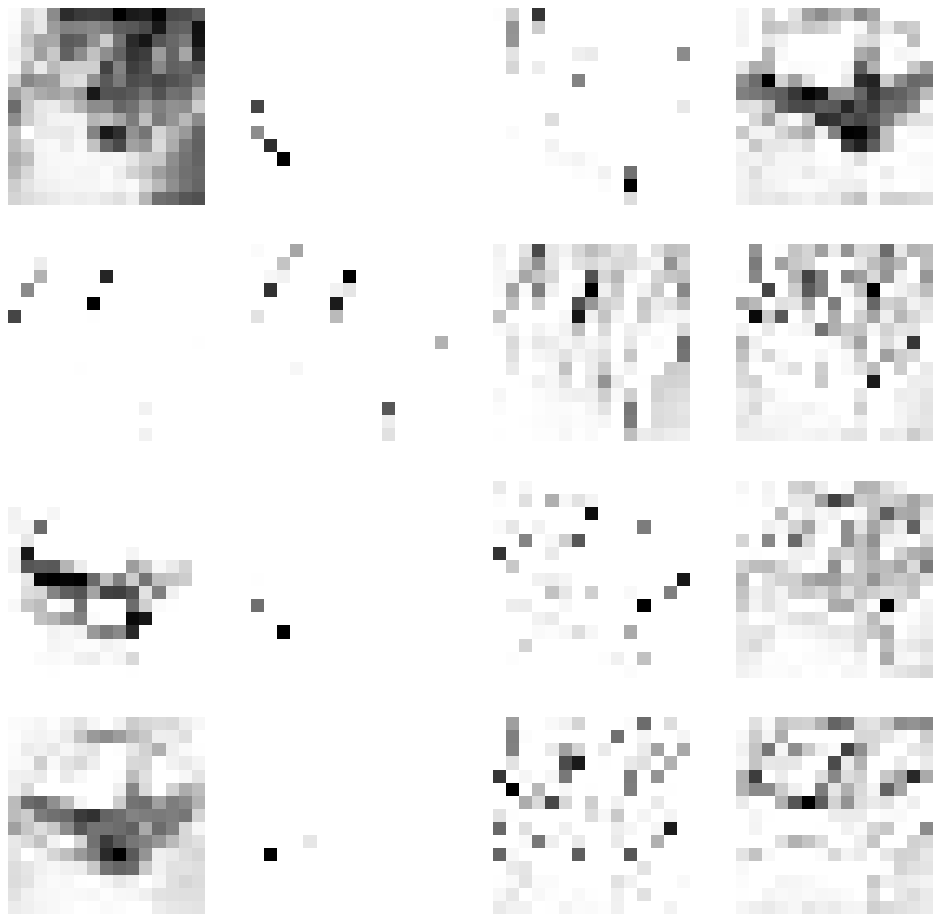

In [101]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15), dpi=80)
for i,ax in enumerate(axes.flatten()):
    ax.imshow(second_predicted_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

Q) What features from your chosen image do you think your model has been able to learn? In terms of filters (weights), what goes on when we add more convolutional layers in our models?


I think from my model, the model was able to learn the bonnet of the car, the windows of the car and the curved shape it takes like that of a squared oval.
As we add more filters the car builds on these features to create more complex features. They may start as an edge but may end p becoming something very complex like a shape

### Task 6.1  Effect of learning rate
Take the best selected model in __Task 5.1__ and change its learning rate to: 
- 6.1.1 any value between 5 and 1.
- 6.1.2 learning rate = any value between 0.6 and  0.1 
- 6.1.3 learning rate = 0.00001

and train these three models to compare the effect learning rate.

#### Between 1 and 5

In [0]:
Input_img = Input(shape=(input_shape), name='input_img')

Conv1 = Conv2D(32, kernel_size=(3, 3), strides = (2,2))(Input_img)
# Batchnorm1 = BatchNormalization()(Conv1)
Act1 = Activation('relu')(Conv1)
# Pool1 = MaxPooling2D(pool_size=(2,2), padding='same')(Act1)

Conv2 = Conv2D(64, (3, 3), strides = (2,2))(Act1)
Batchnorm2 = BatchNormalization()(Conv2)
Act2 = Activation('relu')(Batchnorm2)
Pool2 = MaxPooling2D(pool_size=(2,2), padding='same')(Act2)
Dropout1 = Dropout(0.2)(Pool2)

Conv3 = Conv2D(128, (3, 3), strides = (1,1))(Dropout1)
Batchnorm3 = BatchNormalization()(Conv3)
Act3 = Activation('relu')(Batchnorm3)
Pool3 = MaxPooling2D(pool_size=(2,2), padding='same')(Act3)
Dropout2 = Dropout(0.3)(Pool3)

Flat = Flatten()(Dropout2)
Dense1 = Dense(128, activation='relu')(Flat)
Dense2 = Dense(64, activation='relu')(Dense1)
Output_class = Dense(num_classes, activation='softmax')(Dense2)


model_first = Model(inputs=Input_img, outputs=Output_class)

In [0]:
adam = Adam(lr=1)
model_first.compile(optimizer= adam ,loss= 'categorical_crossentropy', metrics=['accuracy'])

In [109]:
hist_first = model_first.fit_generator( 
    train_gen,
    epochs=epochs,
    steps_per_epoch=len(y_train)//batch_size,
    verbose=1, 
    validation_data=val_gen,
    validation_steps=len(y_val)//batch_size, 
    )

Epoch 1/25
625/625 [==============================] - 12s 19ms/step - loss: 14.5119 - acc: 0.0985 - val_loss: 14.4052 - val_acc: 0.1063
Epoch 2/25
625/625 [==============================] - 10s 16ms/step - loss: 14.5470 - acc: 0.0975 - val_loss: 14.3955 - val_acc: 0.1069
Epoch 3/25
625/625 [==============================] - 10s 16ms/step - loss: 14.5256 - acc: 0.0988 - val_loss: 14.4036 - val_acc: 0.1064
Epoch 4/25
625/625 [==============================] - 10s 16ms/step - loss: 14.5176 - acc: 0.0993 - val_loss: 14.3923 - val_acc: 0.1071
Epoch 5/25
625/625 [==============================] - 10s 16ms/step - loss: 14.5325 - acc: 0.0984 - val_loss: 14.4311 - val_acc: 0.1047
Epoch 6/25
625/625 [==============================] - 10s 15ms/step - loss: 14.5357 - acc: 0.0982 - val_loss: 14.3487 - val_acc: 0.1098
Epoch 7/25
625/625 [==============================] - 10s 16ms/step - loss: 14.5341 - acc: 0.0983 - val_loss: 14.4230 - val_acc: 0.1052
Epoch 8/25
625/625 [============================

#### Between 0.1 and 0.6

In [0]:
Input_img = Input(shape=(input_shape), name='input_img')

Conv1 = Conv2D(32, kernel_size=(3, 3), strides = (2,2))(Input_img)
# Batchnorm1 = BatchNormalization()(Conv1)
Act1 = Activation('relu')(Conv1)
# Pool1 = MaxPooling2D(pool_size=(2,2), padding='same')(Act1)

Conv2 = Conv2D(64, (3, 3), strides = (2,2))(Act1)
Batchnorm2 = BatchNormalization()(Conv2)
Act2 = Activation('relu')(Batchnorm2)
Pool2 = MaxPooling2D(pool_size=(2,2), padding='same')(Act2)
Dropout1 = Dropout(0.2)(Pool2)

Conv3 = Conv2D(128, (3, 3), strides = (1,1))(Dropout1)
Batchnorm3 = BatchNormalization()(Conv3)
Act3 = Activation('relu')(Batchnorm3)
Pool3 = MaxPooling2D(pool_size=(2,2), padding='same')(Act3)
Dropout2 = Dropout(0.3)(Pool3)

Flat = Flatten()(Dropout2)
Dense1 = Dense(128, activation='relu')(Flat)
Dense2 = Dense(64, activation='relu')(Dense1)
Output_class = Dense(num_classes, activation='softmax')(Dense2)


model_second = Model(inputs=Input_img, outputs=Output_class)

In [0]:
adam = Adam(lr=0.1)
model_second.compile(optimizer= adam ,loss= 'categorical_crossentropy', metrics=['accuracy'])

In [114]:
hist_second = model_second.fit_generator( 
    train_gen,
    epochs=epochs,
    steps_per_epoch=len(y_train)//batch_size,
    verbose=1, 
    validation_data=val_gen,
    validation_steps=len(y_val)//batch_size, 
    )

Epoch 1/25
625/625 [==============================] - 12s 19ms/step - loss: 14.5082 - acc: 0.0988 - val_loss: 14.3859 - val_acc: 0.1075
Epoch 2/25
625/625 [==============================] - 10s 16ms/step - loss: 14.5349 - acc: 0.0982 - val_loss: 14.3842 - val_acc: 0.1076
Epoch 3/25
625/625 [==============================] - 10s 16ms/step - loss: 14.5256 - acc: 0.0988 - val_loss: 14.4165 - val_acc: 0.1056
Epoch 4/25
625/625 [==============================] - 10s 16ms/step - loss: 14.5349 - acc: 0.0982 - val_loss: 14.3778 - val_acc: 0.1080
Epoch 5/25
625/625 [==============================] - 10s 16ms/step - loss: 14.5341 - acc: 0.0983 - val_loss: 14.4424 - val_acc: 0.1040
Epoch 6/25
625/625 [==============================] - 10s 16ms/step - loss: 14.5401 - acc: 0.0979 - val_loss: 14.3842 - val_acc: 0.1076
Epoch 7/25
625/625 [==============================] - 10s 16ms/step - loss: 14.5276 - acc: 0.0987 - val_loss: 14.3955 - val_acc: 0.1069
Epoch 8/25
625/625 [============================

#### 0.00001

In [0]:
Input_img = Input(shape=(input_shape), name='input_img')

Conv1 = Conv2D(32, kernel_size=(3, 3), strides = (2,2))(Input_img)
# Batchnorm1 = BatchNormalization()(Conv1)
Act1 = Activation('relu')(Conv1)
# Pool1 = MaxPooling2D(pool_size=(2,2), padding='same')(Act1)

Conv2 = Conv2D(64, (3, 3), strides = (2,2))(Act1)
Batchnorm2 = BatchNormalization()(Conv2)
Act2 = Activation('relu')(Batchnorm2)
Pool2 = MaxPooling2D(pool_size=(2,2), padding='same')(Act2)
Dropout1 = Dropout(0.2)(Pool2)

Conv3 = Conv2D(128, (3, 3), strides = (1,1))(Dropout1)
Batchnorm3 = BatchNormalization()(Conv3)
Act3 = Activation('relu')(Batchnorm3)
Pool3 = MaxPooling2D(pool_size=(2,2), padding='same')(Act3)
Dropout2 = Dropout(0.3)(Pool3)

Flat = Flatten()(Dropout2)
Dense1 = Dense(128, activation='relu')(Flat)
Dense2 = Dense(64, activation='relu')(Dense1)
Output_class = Dense(num_classes, activation='softmax')(Dense2)


model_third = Model(inputs=Input_img, outputs=Output_class)

In [0]:
adam = Adam(lr=0.00001)
model_third.compile(optimizer= adam ,loss= 'categorical_crossentropy', metrics=['accuracy'])

In [117]:
hist_third = model_third.fit_generator( 
    train_gen,
    epochs=epochs,
    steps_per_epoch=len(y_train)//batch_size,
    verbose=1, 
    validation_data=val_gen,
    validation_steps=len(y_val)//batch_size, 
    )

Epoch 1/25
625/625 [==============================] - 12s 19ms/step - loss: 2.4353 - acc: 0.1362 - val_loss: 2.1385 - val_acc: 0.2214
Epoch 2/25
625/625 [==============================] - 10s 16ms/step - loss: 2.1465 - acc: 0.2069 - val_loss: 2.0119 - val_acc: 0.2843
Epoch 3/25
625/625 [==============================] - 10s 16ms/step - loss: 2.0436 - acc: 0.2540 - val_loss: 1.9229 - val_acc: 0.3170
Epoch 4/25
625/625 [==============================] - 10s 16ms/step - loss: 1.9744 - acc: 0.2719 - val_loss: 1.8645 - val_acc: 0.3286
Epoch 5/25
625/625 [==============================] - 10s 16ms/step - loss: 1.9167 - acc: 0.2900 - val_loss: 1.8112 - val_acc: 0.3526
Epoch 6/25
625/625 [==============================] - 10s 16ms/step - loss: 1.8765 - acc: 0.3059 - val_loss: 1.7746 - val_acc: 0.3650
Epoch 7/25
625/625 [==============================] - 10s 15ms/step - loss: 1.8348 - acc: 0.3193 - val_loss: 1.7378 - val_acc: 0.3802
Epoch 8/25
625/625 [==============================] - 10s 16ms

### Task 6.2 Plot loss and accuracy
Plot the loss and accracy for best model selected in task 5.1, and model trained in 6.1.1, 6.1.2 and 6.1.3 task. Give the detailed analysis of the effect of learning rate in your words and select the best learning rate for this problem.

In [0]:
# Use plotHistory to make these plots
all_histories_lr = []
all_histories_lr.append(model_first)
all_histories_lr.append(model_second)
all_histories_lr.append(model_third)
labels = ['lr=1', 'lr=0.1', 'lr=0.00001']

Analysis:
It is apparent that at learning rate of 0.00001 we get the highest accuracy and lowest loss. This learning rate is beneficial as we are working with a deep model while large values for learning rate start overstepping and never reach minima. So with small value we make best use of the deep gradient surface.

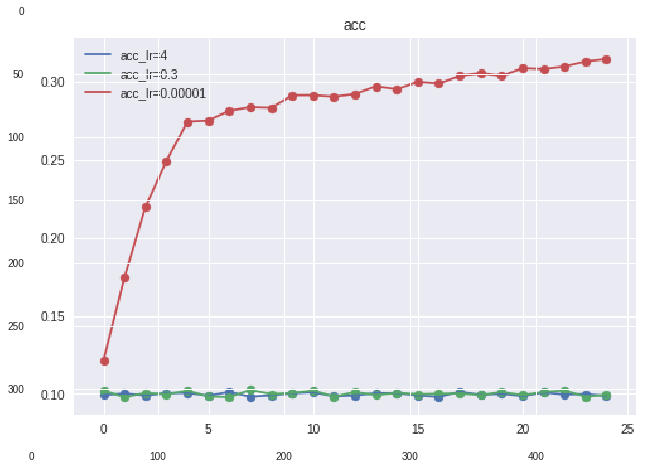

In [10]:
plotHistory(all_histories_lr, labels, 'acc')

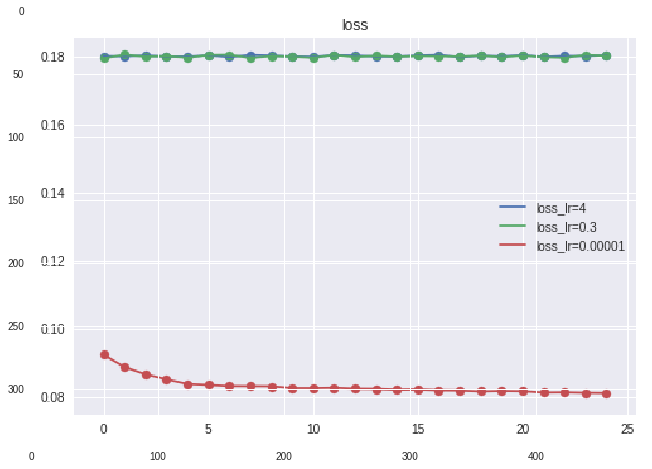

In [12]:
plotHistory(all_histories_lr, labels, 'loss')